# Customised Image Classifier

This is a continuation from last week's image classifier `02a_image_classifier_pytorch.ipynb`. 

Last week, we trained a Convolutional Neural Network (CNN) for image classification, but we didn't pay much attention to how it was built. However, it's important to know about some basic NN building blocks in PyTorch so that you can tweak it for different situations (e.g. adjust input sizes, model sizes, improve performance etc.)

So this week, we're going to cover **how to build a neural network using PyTorch neural network building blocks**. 

We'll be using the same training workflow as last week, but focus on how the CNN model is created.



Before we start, let's config the device PyTorch is using

In [150]:
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

elif torch.backends.mps.is_available():
    device = "mps"

print(f'Using device: {device}')

Using device: mps


## **Step 1** - Prepare Dataset

We'll use the [Flower Recognition](https://aiplanet.com/challenges/61/data-sprint-25-flower-recognition-61/data) dataset for flower classification. 

<u>Please download the dataset from [here](https://drive.google.com/file/d/1v0or9w-z4x0M0SHNFkp9UVZGsJ1G6e_t/view?usp=sharing) and unzip it to the `week-4` folder.</u>


![img](./src/flower_samples.png) 



In [151]:
# we're going to crop all images to this resolution
image_resolution = 64

# how many colour channels?
# 3 for RGB, 1 for greyscale
colour_channels = 3

# make sure the path to your image folder is correct
folder_path = './simpsons/test_images' 

#### **1.1** - Pre-process images 

Pre-process (i.e. crop, resize, normalise) the images in our dataset.

Use [PyTorch's Transforming functions](https://pytorch.org/vision/0.17/transforms.html) to define the pre-processes pipeline on our images. 


In [152]:
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Grayscale, Resize, RandomCrop, Normalize

# this transformation function will help us pre-process images during the training (on-the-fly)
transformation = Compose([   
    # convert an image to tensor
    ToImage(),
    ToDtype(torch.float32, scale=True),
    
    # resize and crop
    Resize(image_resolution),
    RandomCrop(image_resolution),
    
    # normalise pixel values to be between -1 and 1 
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
    # if you're training on greyscale images, convert them to greyscale
    # otherwise just do nothing
    Grayscale() if colour_channels == 1 else torch.nn.Identity()
    
])

#### **1.2** - Create dataset loaders  

Data loaders loads images into batches according to the pre-processes pipeline we have defined previously.

In [153]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch

from IPython.display import display

from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

In [154]:
# how many images are going to be put into the testing set, 
# e.g. 0.2 means 20% percent of images
test_size = 0.2 

# how many images will be used in one epoch, 
# this usually depend on your model / types of data / CPU or GPU's capability
batch_size = 12

There is a lot of discussion about how different batch sizes can affect training results, e.g. [here](https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/). But as a rule of thumb: larger batch sizes can make your gradient less noisy and therefore safer for larger learning rates, but this is always subjected to different models and data, especially when training generative models. So a good way to decide batch sizes is to follow literatures or similar works.

In [155]:
# Instatiate train and test datasets
train_dataset = ImageFolder(folder_path, transform=transformation)
test_dataset = ImageFolder(folder_path, transform=transformation)

# Get length of dataset and indicies
num_train = len(train_dataset)
indices = list(range(num_train))

# Get train / test split for data points
train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

# Override dataset classes to only be samples for each split
train_sub_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_sub_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Create training and tresing data loaders
train_loader = DataLoader(train_sub_dataset, batch_size=batch_size, num_workers=4, multiprocessing_context="forkserver" if device=='mps' else None, shuffle=True)
test_loader = DataLoader(test_sub_dataset, batch_size=batch_size, num_workers=4, multiprocessing_context="forkserver" if device=='mps' else None, shuffle=True)


In [156]:
# sort out the names for each classes (according to the folder names)
class_names = train_dataset.classes

print(f'{len(train_indices)} training images loaded')
print(f'{len(test_indices)} testing images loaded')
print(f'classes: {class_names}')

data, labels = next(iter(train_loader))

print(f'data shape: {data.shape}')
print(f'labels shape: {labels.shape}')

4764 training images loaded
1192 testing images loaded
classes: ['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']
data shape: torch.Size([12, 3, 64, 64])
labels shape: torch.Size([12])


## **Step 2** - create a convolutional neural network model   

Last week we skipped over the details of the neural network and used a script to load an empty one. But this time we'll use PyTorch's neural network building blocks to build it. 

In [157]:
from torch import nn, flatten
from torch.nn.functional import relu

### Convolution Kernel   

Use a 2D matrix of “kernels” to sweep across the image, check PyTorch documentation on [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

`nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)`  

Using `kernel_size = 3` and `padding = 1` will allow us to keep the width and height of the tensor

In [158]:
conv2d_layer = nn.Conv2d(3, 32, kernel_size=3, padding=1)

print(f'input shape {data.shape}')
x = conv2d_layer(data)

print(f'output shape {x.shape}')

input shape torch.Size([12, 3, 64, 64])
output shape torch.Size([12, 32, 64, 64])


### Pooling Kernel   

Shrink down the size of a tensor, check PyTorch documentation on [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

`nn.MaxPool2d(kernel_size=2, stride=2)`  

Using `kernel_size = 2` and `stride = 2` will allow us to reduce widths and heights of the inputs by half 

In [159]:
maxpooling_layer = nn.MaxPool2d(2, 2)

print(f'input shape {x.shape}')
x = maxpooling_layer(x)

print(f'output shape {x.shape}')

input shape torch.Size([12, 32, 64, 64])
output shape torch.Size([12, 32, 32, 32])


### Activation Layer    

Each convolutional layer will be followed by an activation function, they allows us to approximate complex data patterns (see [extended reading](https://machinelearningmastery.com/using-activation-functions-in-neural-networks/)).  
There are a lot of different types of activation functions, check PyTorch [Non-linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). We'll be using `ReLU`.

`nn.ReLU()`  

Activation function won't affect the size of the tensor

In [160]:
activation_layer = nn.ReLU()

print(f'input shape {x.shape}')
x = activation_layer(x)

print(f'output shape {x.shape}')

input shape torch.Size([12, 32, 32, 32])
output shape torch.Size([12, 32, 32, 32])


### Put Them Together

In [161]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        # Call the constructor of the base class nn.module
        super().__init__()

        modules = []
        
        # each convolutional layer will takes a batch of 3D tensor 
        # Outputs a batch of 3D tensor (outputs of all convolutional filters)
        # for the first conv layer, the input channel is 3 because that's the number of colour channels
        modules.append(nn.Conv2d(3, 8, kernel_size=3, padding=1))
        
        # Each conv layer will be followed by a pooling layer and the relu activation function
        # the pooling layer reduce widths and heights of the inputs by half 
        # so the tensor shape change from [8, 64, 64] -> [8, 32, 32] after it
        modules.append(nn.MaxPool2d(2, 2))
        modules.append(nn.ReLU())
        
        # the second conv layer
        # we increase the number of channels, but the widths and heights remain the same
        # so the tensor shape change from [8, 32, 32] -> [16, 32, 32] after it
        modules.append(nn.Conv2d(8, 16, kernel_size=3, padding=1))
        
        # the second pooling and relu layer
        # the tensor shape change from [16, 32, 32] -> [16, 16, 16] after it
        modules.append(nn.MaxPool2d(2, 2))
        modules.append(nn.ReLU())
        
        # the tensor shape change from [16, 16, 16] -> [32, 8, 8] after it
        modules.append(nn.Conv2d(16, 32, kernel_size=3, padding=1))
        modules.append(nn.MaxPool2d(2, 2))
        modules.append(nn.ReLU()) 

        # the tensor shape change from [32, 8, 8] -> [32, 4, 4] after it
        modules.append(nn.Conv2d(32, 32, kernel_size=3, padding=1))
        modules.append(nn.MaxPool2d(2, 2))
        modules.append(nn.ReLU()) 
        
        # We append these modules to a Modules List object so that later we can iterate through it
        self.convolutions = nn.ModuleList(modules)
        
        # First fully connected layer
        # Its input size depend on the convolutional layer's output resolution and the number of channels
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        
        # Last fully connected layer
        # Outputs a vector of class predictions,
        # make sure the output channel is the number of classes you have
        self.fc2 = nn.Linear(32, 5)
        

    # Definition of the forward pass
    # Here the classifier takes an image as input and predicts an vector of probabilites
    def forward(self, x):

        # Pass input through all layers we have added
        for layer in self.convolutions:
            x = layer(x)
            
        # Flatten the output of the last convolutional layer into a 1-dimensional vector
        x = flatten(x, 1) 
        
        # Pass through the first and the second fully connected layer with relu activation function
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        
        # Output a vector of class probabilities
        return x

In [162]:
model = ConvNeuralNetwork()
model.to(device)

ConvNeuralNetwork(
  (convolutions): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
)

## **Step 3** - Train the model

The following sections will be exactly the same with last week's image classifier.  
If you need a refresh, check the `02a_image_classifier_pytorch.ipynb` notebook in week3.



#### Define optimiser and loss function

In [163]:
# Cross entropy loss
loss_function = torch.nn.CrossEntropyLoss().to(device)

# Adam optimizer 　　
optimizer = torch.optim.Adam(model.parameters())

#### Define training/ testing loop  

In [164]:
# we can save the model regularly
save_every_n_epoch = 5

# total number of epochs we aim for
num_epochs = 15

# keep track of the losses, we can plot them in the end
train_losses = []
test_losses = []

print('Epoch 0')

for epoch in range(num_epochs): 

    #---- Training loop -----------------------------
    train_loss = 0.0
    model.train()
    
    for i, data in enumerate(train_loader, 0):
        # Load: The training data loader loads a batch of training data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)
        
        # Pass: Forward pass the training data to our model, and get the predicted classes.
        pred_labels = model(inputs)
        
        # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
        loss = loss_function(pred_labels, true_labels)
        train_loss += loss.item()
        
        # Optimise: The optimizer slightly optimises our model based on the error.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i % 50 == 0:
            print(f'  -> Step {i + 1:04}, train loss: {loss.item():.4f}')
    
    
    #---- Testing loop -----------------------------
    test_loss = 0.0
    model.eval()
    
    with torch.inference_mode():
        test_loss = 0.0
        for i, data in enumerate(test_loader, 0):
            # Load: The testing data loader loads a batch of testing data and their true class labels.
            inputs, true_labels = data
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)
            
            # Pass: Forward pass the testing data to our model, and get the predicted classes.
            pred_labels = model(inputs)
            
            # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
            loss = loss_function(pred_labels, true_labels)
            test_loss += loss.item()
    
    
    #---- Report some numbers -----------------------------
    
    # Calculate the cumulative losses in this epoch
    train_loss = train_loss / len(train_loader)
    test_loss = test_loss / len(test_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')
    
    # save our model every n epoch
    if (epoch+1) % save_every_n_epoch==0:
        torch.save(model.state_dict(), f'model_epoch{epoch:04}.pt')
        
# save the model at the end of the training process
torch.save(model.state_dict(), f'model_final.pt')

print("training finished, model saved to 'model_final.pt'")

Epoch 0
  -> Step 0001, train loss: 1.6060
  -> Step 0051, train loss: 1.2762
  -> Step 0101, train loss: 1.2733
  -> Step 0151, train loss: 1.2486
  -> Step 0201, train loss: 1.4242
  -> Step 0251, train loss: 1.0134
  -> Step 0301, train loss: 1.0259
  -> Step 0351, train loss: 1.2586
Epoch 1, train loss: 1.154, test loss: 1.009
  -> Step 0001, train loss: 0.8131
  -> Step 0051, train loss: 1.1169
  -> Step 0101, train loss: 0.5452
  -> Step 0151, train loss: 0.8398
  -> Step 0201, train loss: 0.6074
  -> Step 0251, train loss: 0.9624
  -> Step 0301, train loss: 0.9801
  -> Step 0351, train loss: 0.9150
Epoch 2, train loss: 0.881, test loss: 0.858
  -> Step 0001, train loss: 0.7302
  -> Step 0051, train loss: 0.6531
  -> Step 0101, train loss: 1.5148
  -> Step 0151, train loss: 0.8337
  -> Step 0201, train loss: 0.7222
  -> Step 0251, train loss: 1.4721
  -> Step 0301, train loss: 0.6183
  -> Step 0351, train loss: 0.2396
Epoch 3, train loss: 0.766, test loss: 0.783
  -> Step 0001, t

#### Plot Training Process


In [165]:
import matplotlib.pyplot as plt
import numpy as np

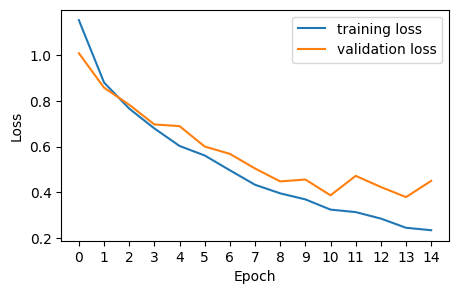

In [166]:
plt.figure(figsize=(5,3))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label = 'validation loss')
plt.xticks(np.arange(len(train_losses)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## **Step 4** - Test and evaluate the training results   

#### Load model  
First, let's load our trained model. And set the model to 'evaluation' mode `.eval()` (check [torch.nn.Module.eval()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval))

In [167]:
# make sure the parameters are the same as when the model is created
eval_model = ConvNeuralNetwork()

# load the saved model, make sure the path is correct
eval_model.load_state_dict(torch.load('model_final.pt'))

eval_model.to(device)
eval_model.eval() 

ConvNeuralNetwork(
  (convolutions): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
)

#### Load some test data 

Data in the testing set has never been exposed to the model during the training process, so they are good to test if our model works fine on "new" data. Why? Because sometimes the model begins to **overfit** to the training set and is not able to "generalise" to data that are not in the training set.

In [168]:
test_data, test_labels = next(iter(test_loader))

true_label = class_names[test_labels[0]]

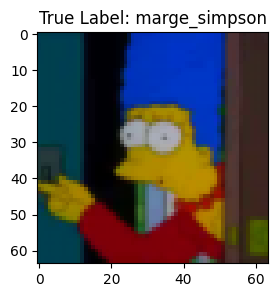

In [169]:
plt.figure(figsize=(3,3))
plt.title(f"True Label: {true_label}")
plt.imshow(test_data[0].add(1).div(2).permute((1,2,0)).cpu().detach().numpy())

plt.show()

Run it through a forward pass

In [170]:
with torch.inference_mode():
    pred_labels = eval_model(test_data.to(device))

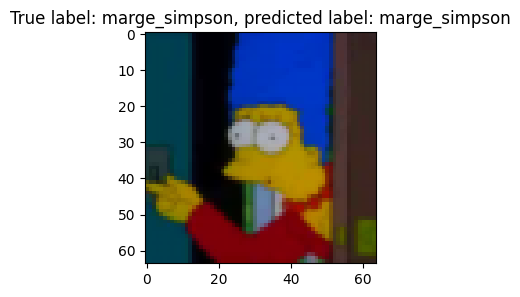

In [171]:
_, predicted_class_index = torch.max(pred_labels[0], 0)

plt.figure(figsize=(3,3))
plt.title(f"True label: {true_label}, predicted label: {class_names[predicted_class_index]}")
plt.imshow(test_data[0].add(1).div(2).permute((1,2,0)).cpu().detach().numpy())

plt.show()

#### Calculate accuracy  

Now we can run our model on the full testing set to calculate the accuracy of our model.  
In practice, we'll keep counting the correct predictions and check what percentage of the predictions are correct.

In [172]:
num_samples = 0
num_correct = 0

with torch.inference_mode():
    for i, data in enumerate(test_loader, 0):
        # Load: The testing data loader loads a batch of testing data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)

        # Pass: Forward pass the testing data to our model, and get the predicted classes.
        pred_labels = eval_model(inputs)
        pred_labels = torch.argmax(pred_labels, dim=1)
        
        num_correct += pred_labels.size(0) - torch.count_nonzero(pred_labels - true_labels)
        num_samples += pred_labels.size(0) 
        
accuracy = num_correct / num_samples
print(f'correct samples: {num_correct}  \ntotal samples: {num_samples}  \nmodel accuracy: {accuracy:.3f}')

correct samples: 1015  
total samples: 1192  
model accuracy: 0.852


## Tasks

After you went through all the code in this notebook, **make a copy of this notebook** before working on the tasks so that we can have a direct comparison of the results.

### Task 1 
Find a different dataset for a different classification task. For example, this [fashion dataset](https://www.kaggle.com/datasets/cryforme/fashiondatatrainsc3), or go to [kaggle.com](https://www.kaggle.com/datasets), choose a dataset that you're interested in (perhaps filtering to Computer Vision datasets only if you're interested in using CNNs). Split the dataset into training and testing sets, and load them into `DataLoader` like in the example code.

> I downloaded the Simpson's dataset from Kaggle. The structure of the dataset is already consistent with the original data structure, so I directly used this dataset.
>
> Moreover, the dataset is quite large, containing a total of 5000 images, which is why I did not apply data augmentation.
>
> Dataset link: https://www.kaggle.com/datasets/mlwhiz/simpsons-main-characters


### Task 2
Go to the cell that defines the convolutional neural network and adjust it to fit the dataset you chose (you might want to add or remove a few convolutional layers). And do some experimentations, try changing at least two of the following:
 

#### original result
* model accuracy: 0.846

#### 01: change the batch size
> batch_size = 16 -> 12
* model accuracy: 0.868

#### 02: change the Number of training epochs
> epochs = 10 -> 15
* model accuracy: 0.852

#### 03: change the optimizer
> torch.optim.Adam(model.parameters())->torch.optim.Adam(model.parameters(), lr=1e-4)
* model accuracy: 0.639

> torch.optim.Adam(model.parameters(), lr=1e-4)->torch.optim.Adam(model.parameters(), lr=1e-5)
* model accuracy: 0.481

> torch.optim.Adam(model.parameters(), lr=1e-4)->torch.optim.Adam(model.parameters(), lr=1e-5)
* model accuracy: 0.585
 

### Task 3

* In my current experiments, I have tried different optimizers and loss functions, but none of them yielded significantly better results.
* Based on my previous experience, increasing the number of training epochs usually improves accuracy.
* I’m confused by the fact that reducing the learning rate (lr) actually resulted in worse accuracy. I may conduct further experiments on this. (I expected that lowering the learning rate would require more training epochs, but simply increasing the number of epochs alone already improves accuracy.)
* According to the documentation, for a classification task where each image belongs to only one class, torch.nn.CrossEntropyLoss() is indeed the most appropriate choice. BCEWithLogitsLoss() is not suitable for single-label classification. GPT also suggested trying NLLLoss combined with log_softmax, but this requires manually applying log_softmax, which I haven't fully explored yet.
* Additionally, I don’t yet have a solid understanding of the entire network architecture. I tried modifying the parameters of MaxPool2d, but encountered some errors. I plan to spend more time studying the structure of the network.
